# Aggregation

## What is aggregation?

The act of collapsing many rows into few rows.

In [4]:
from pyspark.sql import SparkSession
from more_pyspark import get_spark_types, to_pandas

spark = SparkSession.builder.appName('Ops').getOrCreate()
pitching_spark =  spark.read.csv('data/baseball/core/Pitching.csv', inferSchema=True, header=True)

In [6]:
(pitching_spark
 .take(5)
) >> to_pandas

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NA,1,2,3,3,2,...,None,7,None,0,146,0,42,None,None,None
1,brainas01,1871,1,WS3,NA,12,15,30,30,30,...,None,7,None,0,1291,0,292,None,None,None
2,fergubo01,1871,1,NY2,NA,0,0,1,0,0,...,None,2,None,0,14,0,9,None,None,None
3,fishech01,1871,1,RC1,NA,4,16,24,24,22,...,None,20,None,0,1080,1,257,None,None,None
4,fleetfr01,1871,1,NY2,NA,0,1,1,1,1,...,None,0,None,0,57,0,21,None,None,None


## Simple Aggregation

A **simple aggregation** collapses all rows into one row.

<img src="./img/simple_aggregation.png" width=800>

## Simple aggregation in `pyspark`

In [15]:
import pyspark.sql.functions as fn
(pitching_spark
  .agg(fn.mean('ERA').alias('mean_ers'),
       fn.stddev('ERA').alias('sd_era'),
       fn.max('W').alias('max_wins'),
       fn.min('W').alias('min_wins'))
  .collect()
) >> to_pandas

,mean_ers,sd_era,max_wins,min_wins
0,5.11792,5.466654,60,0


In [16]:
from pyspark.sql.functions import mean, stddev, col
(pitching_spark
  .agg(mean(col('ERA')).alias('mean_ers'),
       stddev(col('ERA')).alias('sd_era'))
  .collect()
) >> to_pandas

,mean_ers,sd_era
0,5.11792,5.466654


## <font color="red"> Exercise 1 </font>

The [dead ball era](https://en.wikipedia.org/wiki/Dead-ball_era) in MLB includes the year from about 1900 to 1918, which was known for a low number of runs per game.  After this period, the number of runs per game increased dramatically and one possible reason for this change was a changes made to the baseball at the start of the 1920 season.    

**Tasks:** Complete that following tasks using `pyspark.sql`

* Compute the average runs allowed per pitcher (column `R`) for the following two ranges of years: 
    * 1900-1919 and 
    * 1920-1939.  
* Is there evidence of a difference in the number of runs allowed for each era?

In [12]:
# Your code here

> *Your thoughts here*

## Group and Aggregate

Group and aggregate

* combines multiple filter + aggregates
* considers all possible groups.

<img src="./img/group_and_aggregate.png" width=800>

In [30]:
from pyspark.sql.functions import when, col

eras = (pitching_spark
        .where((col('yearID') >= 1900) & (col('yearID') < 1940))
        .withColumn('era', (when(col('yearID') < 1920, "dead ball")
                           .otherwise("after dead ball" )))
       )
eras.take(5) >> to_pandas

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,baileha01,1900,1,BSN,NL,0,0,4,1,0,...,None,3,2,0,94,2,16,None,None,None
1,bernhbi01,1900,1,PHI,NL,15,10,32,27,20,...,None,11,5,1,986,5,151,None,None,None
2,breitte01,1900,1,CIN,NL,10,10,24,20,18,...,None,4,14,0,846,3,111,None,None,None
3,callani01,1900,1,CHN,NL,13,16,32,32,32,...,None,8,22,0,1256,0,195,None,None,None
4,carribi01,1900,1,NY1,NL,19,22,45,41,32,...,None,7,13,0,1493,4,224,None,None,None


<img src="./img/filter_group_aggregate.png" width=800>

What we did here is actually `filter + groupby + aggregate`

## Using `groupby` and `agg` 

In [37]:
mean_runs = (eras
             .groupby(col('era'))
             .agg(mean(col('R')).alias('mean_runs'))
            )
out_pandas = mean_runs.collect() >> to_pandas
out_pandas

,era,mean_runs
0,dead ball,49.707696
1,after dead ball,55.289698


## Visualizing the data with `seaborn`

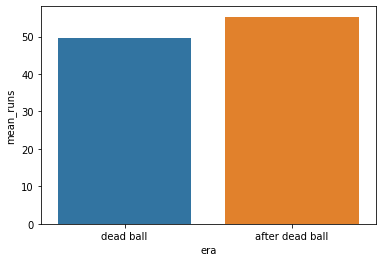

In [38]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
sns.barplot(x = "era", y="mean_runs", data=out_pandas)

## <font color="red"> Exercise 2 </font>

Compose the two queries into one dot-chained expression

In [21]:
# Your code here

## Grouping by more than one category

* `group_by` accepts multiple columns
* Groups all combinations

In [43]:
from pyspark.sql.functions import sum

(pitching_spark
 .select(col('yearID'), col('teamID'), col('W'))
 .groupby(col('yearID'), col('teamID'))
 .agg(sum(col('W')).alias('total_wins'))
 .where(col('total_wins') >= 100)
 .sort(col('yearID').asc(), col('total_wins').desc())
 .take(5)
) >> to_pandas

,yearID,teamID,total_wins
0,1892,BSN,102
1,1898,BSN,102
2,1902,PIT,102
3,1904,NY1,106
4,1905,NY1,105


## <font color="red"> Exercise 3 </font>

The query is pretty complicated.  Let's refactor the expression to improve readability.

1. Move the `when` expression out of the main query, assign it to a good name, then use the new name in the main query.
2. Do something similar with the expression inside the `where` and `agg` clauses.

In [44]:
# Your refactored code here

## The last comparison might not be fair

Comparison is only fair if pitchers all pitch the same number of outs/games/innings.  Let's see if there is a difference between the eras in terms of outs pitched (`IPouts`).

## <font color="red"> Exercise 4 </font>

Below you will find the `pandas + dfply` solution that makes a more fair comparison.  Convert this piped expression to a `pyspark.sql` dot-chained expression.  Note that you will need to

1. Convert intentions to column expressions
2. Switch the `>>` to `.`
3. Switch the `dfply` function to the corresponding `pyspark.sql` method (e.g., `mutate` ==> `withColumn`)

In [47]:
#Pandas code
import pandas as pd
from dfply import *

pitching = pd.read_csv('./data/baseball/core/Pitching.csv')
mean_runs_per_out = (pitching
                     >> select(X.IPouts, X.yearID, X.R)
                     >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
                     >> group_by(X.yearID)
                     >> summarise(total_runs = X.R.sum(),
                                  total_ipouts = X.IPouts.sum())
                     >> ungroup
                     >> mutate(runs_per_out = X.total_runs/X.total_ipouts,
                               era = ifelse(X.yearID < 1920, 
                                            "dead ball", 
                                            "after dead ball"))
                     >> group_by(X.era)
                     >> summarise(mean_runs_per_out = mean(X.runs_per_out))
                    )
mean_runs_per_out

,era,mean_runs_per_out
0,after dead ball,0.182218
1,dead ball,0.149920


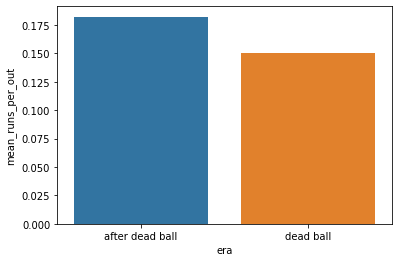

In [48]:
sns.barplot(x = "era", y="mean_runs_per_out", data=mean_runs_per_out)